In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#%%shell
#cd /content/gdrive/MyDrive/11-777/alfred
#export ALFRED_ROOT=$(pwd)

In [3]:
#%%shell
#cd /content/gdrive/MyDrive/11-777/
#git clone https://github.com/hariharan98m/multimodal-alfred.git alfred

In [4]:
#%%shell
#cd /content/gdrive/MyDrive/11-777/alfred/data
#sh download_data.sh json_feat

In [5]:
import os
import json
from collections import defaultdict, Counter
import tqdm

root = "/content/gdrive/MyDrive/11-777/alfred/data/json_feat_2.1.0/"
output_dir = "/content/gdrive/MyDrive/11-777/data_analysis/"

if False:
    with open(os.path.join(output_dir, "res.json"), "r") as f:
        all = json.load(f)
else:
    filename = "traj_data.json"
    all = dict()
    for r in ["valid_seen", "valid_unseen"]:
        for dir in os.listdir(os.path.join(root, r)):
            for sub in os.listdir(os.path.join(root, r, dir)):
                with open(os.path.join(root, r, dir, sub, filename), "r") as f:
                    data = json.load(f)
                    summary = dict()
                    objects = []
                    for level, l in data["plan"].items():
                        summary[level] = defaultdict(int)
                        for action in l:
                            summary[level][action["discrete_action"]["action"]] += 1
                            if action["discrete_action"]["action"] == "PickupObject" and level == "high_pddl":
                                objects.append(action["discrete_action"]["args"][0])
                    length = {level:len(l) for level, l in data["plan"].items()}
                    all[dir] = {"task_type":data["task_type"], "count":summary, "length":length, "objects":objects}
    with open(os.path.join(output_dir, "res.json"), "w") as f:
        json.dump(all, f)

In [6]:
task = []
high = []
low = []
obj = defaultdict(int)
obj_count = []
high_count = Counter()
low_count = Counter()
count = []
action = []
t = []
level = []
for s in all.values():
    task.append(s["task_type"])
    high.append(s["length"]["high_pddl"])
    low.append(s["length"]["low_actions"])
    high_count += Counter(s["count"]["high_pddl"])
    low_count += Counter(s["count"]["low_actions"])
    obj_count.append(len(s["objects"]))
    for o in s["objects"]:
        obj[o] += 1

    for l, d in s["count"].items():
        for k, v in d.items():
            t.append(s["task_type"])
            level.append(l)
            action.append(k)
            count.append(v)

In [7]:
import pandas as pd
df = pd.DataFrame({"task":task,"low":low,"high":high,"obj":obj_count})
#df = pd.DataFrame({"task":t,"level":level,"action":action,"count":count})
task_map = {
    'pick_and_place_simple': 'Pick & Place',
    'pick_cool_then_place_in_recep' : 'Cool & Place',
    'pick_two_obj_and_place': 'Pick Two & Place',              
    'pick_and_place_with_movable_recep': 'Stack & Place',
    'pick_clean_then_place_in_recep': 'Clean & Place',
    'pick_heat_then_place_in_recep': 'Heat & Place',
    'look_at_obj_in_light': 'Examine in Light'
}
df['task'] = df['task'].map(task_map)
df

,task,low,high,obj
0,Examine in Light,43,5,1
1,Pick & Place,21,4,1
2,Clean & Place,45,6,1
3,Cool & Place,58,7,1
4,Pick Two & Place,79,9,2
...,...,...,...,...
322,Pick & Place,62,4,1
323,Cool & Place,64,6,1
324,Cool & Place,60,7,1
325,Examine in Light,53,5,1


In [8]:
df.low.mean(), df.high.mean()

(50.027522935779814, 7.409785932721713)

In [9]:
df[df.high >= 14]

,task,low,high,obj
18,Stack & Place,77,14,3
123,Pick Two & Place,113,17,4
140,Stack & Place,86,14,3
197,Stack & Place,136,14,3


In [10]:
import itertools
a = sorted(high_count.items(), key=lambda x:x[1], reverse=True)
b = sorted(low_count.items(), key=lambda x:x[1], reverse=True)
for i, (x, y) in enumerate(itertools.zip_longest(a, b, fillvalue=("", ""))):
    print(f"{i+1} & {x[0]} & {x[1]} & {y[0]} & {y[1]} \\\\".replace("_", "\\_"))

1 & GotoLocation & 1027 & MoveAhead\_25 & 9741 \\
2 & PickupObject & 465 & RotateRight\_90 & 1419 \\
3 & PutObject & 416 & RotateLeft\_90 & 1363 \\
4 & NoOp & 272 & LookDown\_15 & 972 \\
5 & SliceObject & 52 & LookUp\_15 & 698 \\
6 & CoolObject & 50 & PickupObject & 610 \\
7 & CleanObject & 48 & PutObject & 561 \\
8 & HeatObject & 47 & CloseObject & 355 \\
9 & ToggleObject & 46 & OpenObject & 352 \\
10 &  &  & ToggleObjectOn & 141 \\
11 &  &  & ToggleObjectOff & 95 \\
12 &  &  & SliceObject & 52 \\


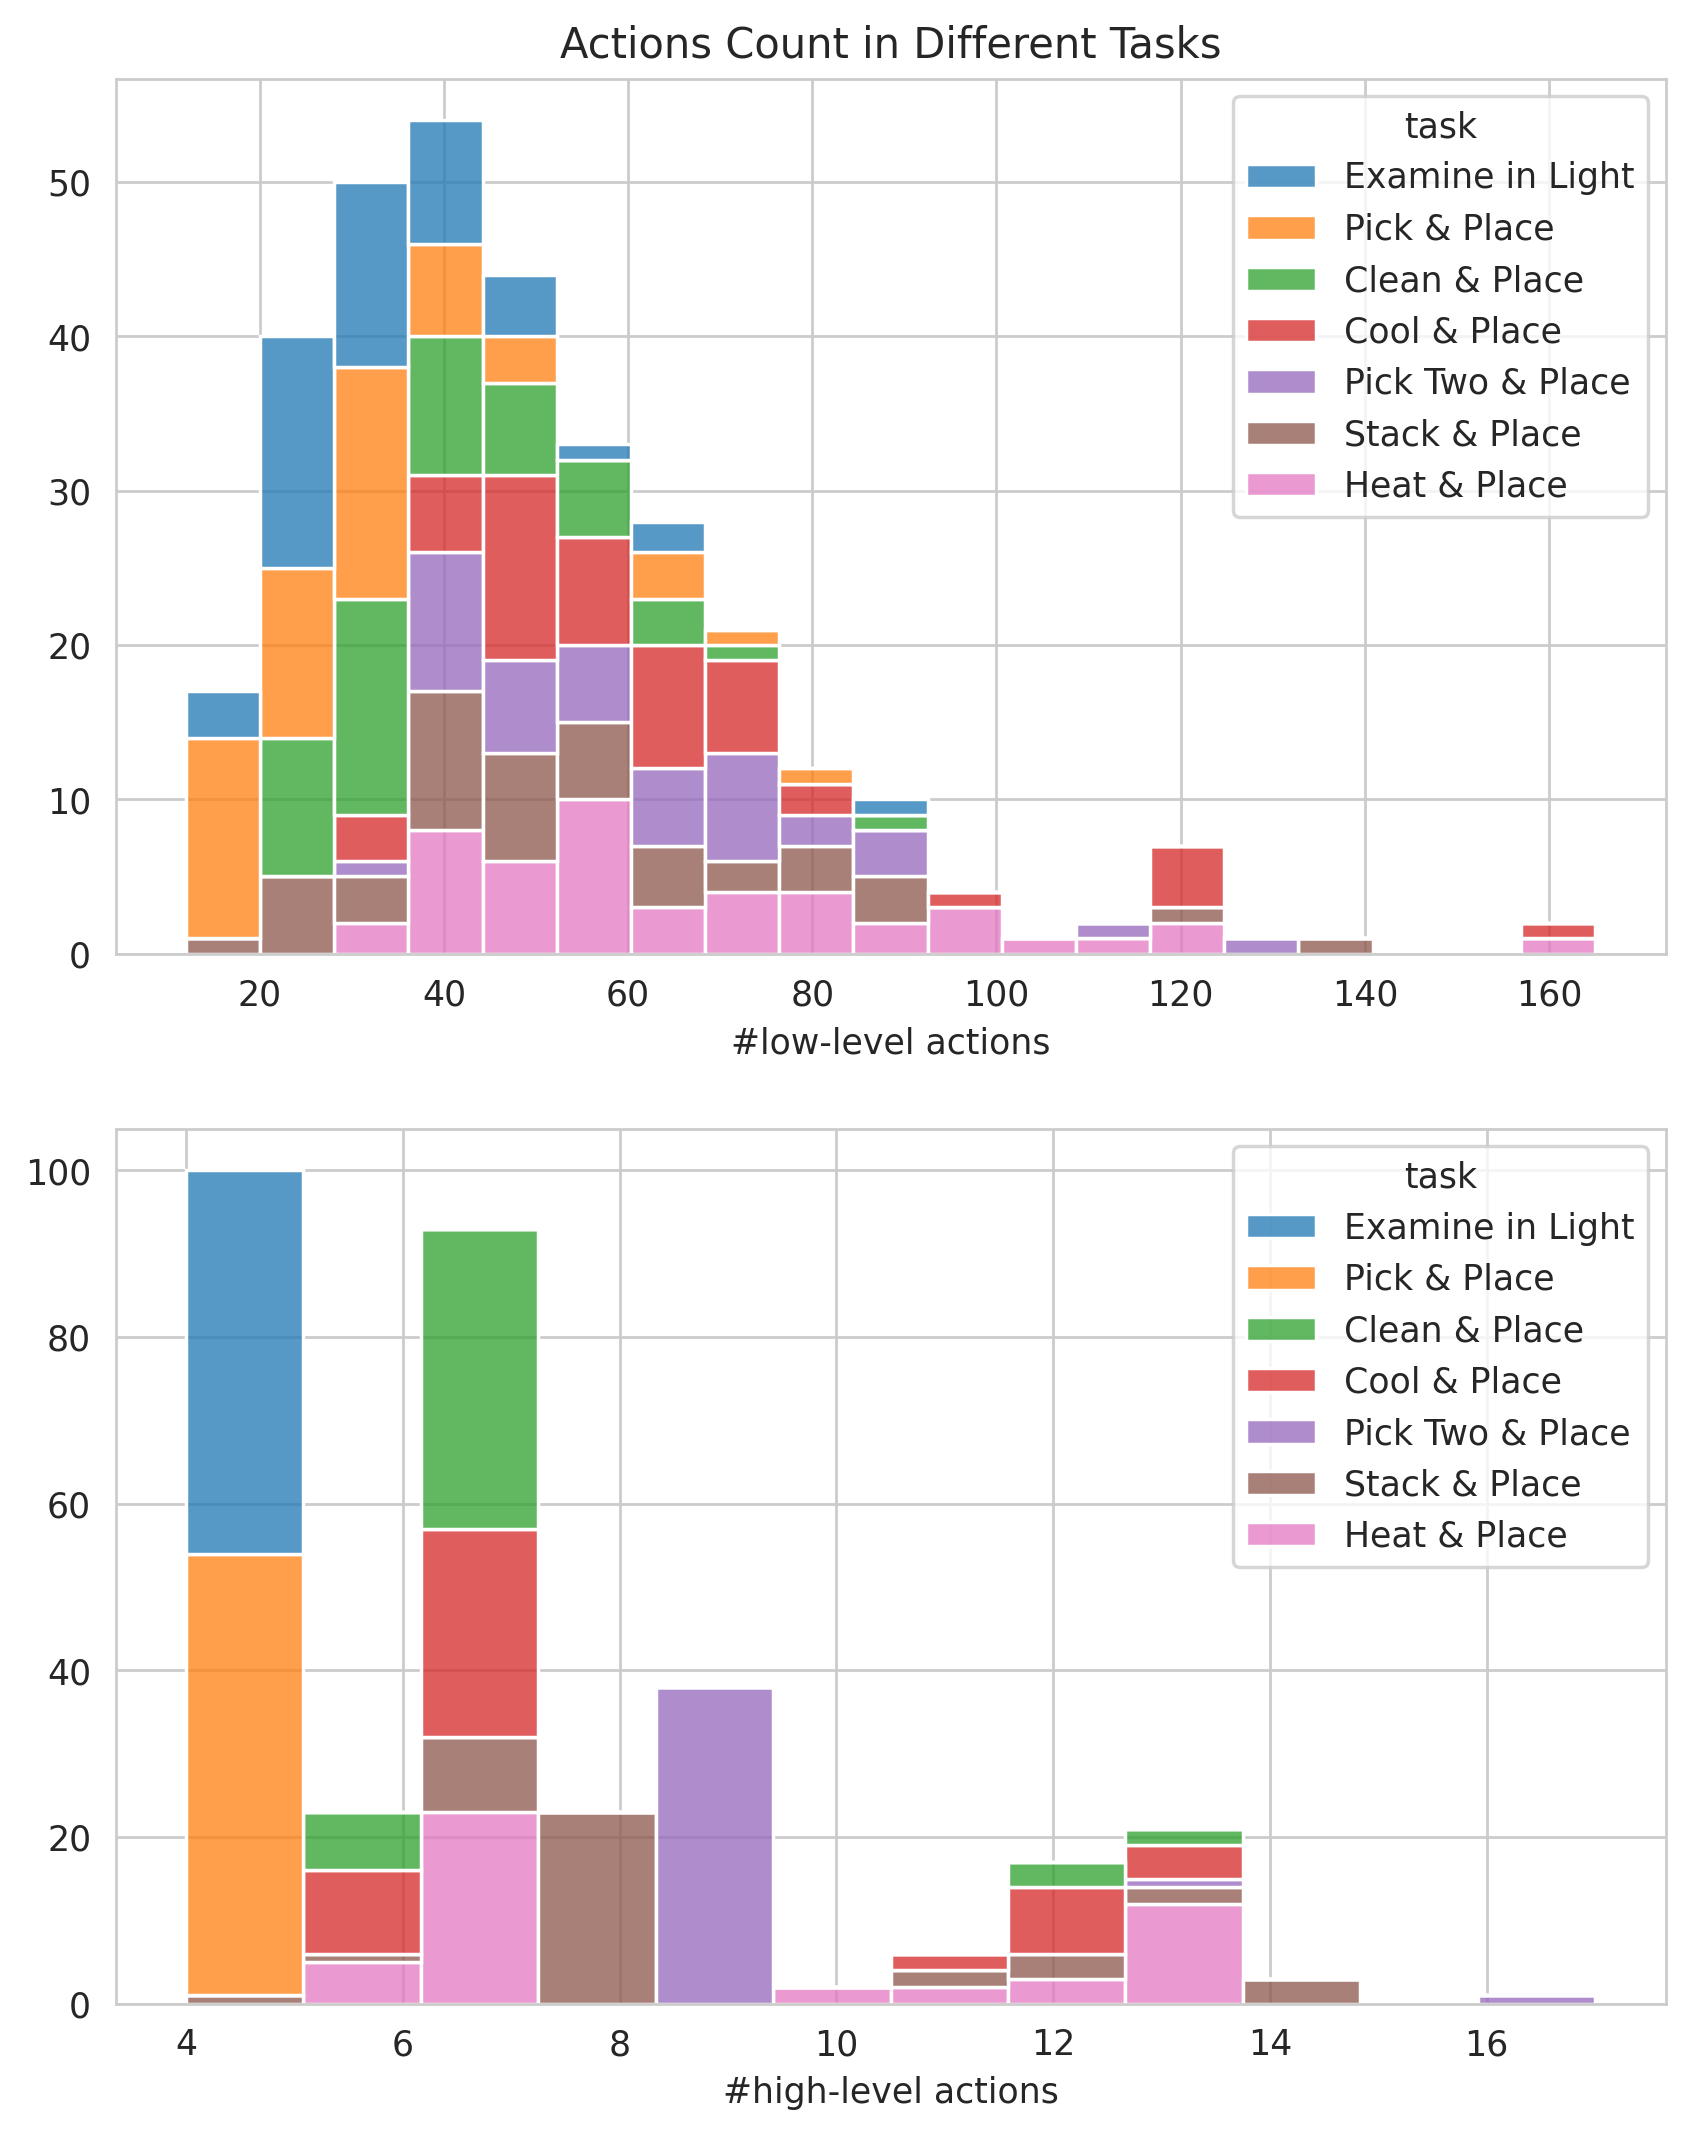

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5.1*2), dpi = 250)
ax0 = sns.histplot(df, x="low", hue="task", multiple="stack",ax=axes[0])
ax0.set(xlabel = '#low-level actions', ylabel = None,  title = 'Actions Count in Different Tasks')
ax1 = sns.histplot(df, x="high", hue="task", multiple="stack", ax = axes[1])
ax1.set(xlabel = '#high-level actions', ylabel = None)
plt.savefig(os.path.join(output_dir, 'task_action_count.pdf'), bbox_inches='tight')

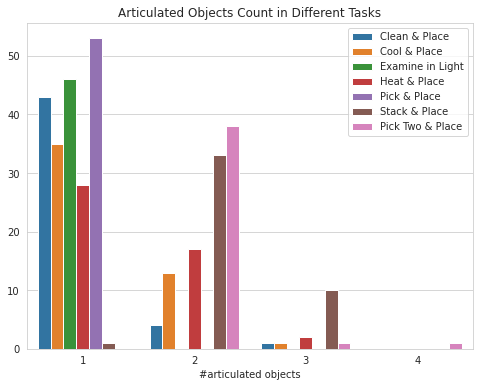

In [12]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data=df.groupby(["obj", "task"],as_index=False)["low"].agg('count'), x="obj", y="low", hue="task")
ax.legend(loc="upper right")
ax.set(xlabel = '#articulated objects', ylabel = None,  title = 'Articulated Objects Count in Different Tasks')
plt.savefig(os.path.join(output_dir, 'task_object_count.pdf'), bbox_inches='tight')

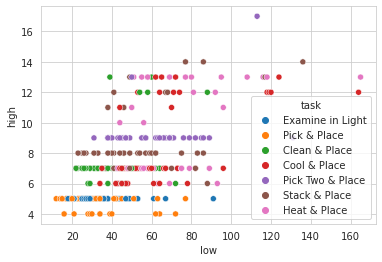

In [13]:
sns.scatterplot(data=df, x="low", y="high", hue="task")